# Применение методов машинного обучения ко временным рядам

In [90]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('seaborn-poster')

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import roc_curve, precision_recall_curve, roc_auc_score, confusion_matrix, mean_squared_error
from sklearn import linear_model
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
import warnings
warnings.filterwarnings("ignore")

Известные нам методы машинного обучения до этого были применены к неупорядоченным данным, что не накладывало ограничений, например, на разбиение выборки на train и test, а также не противоречило тому, что элементы выборки независимы. Теперь же необходимо выполнить преобразования, благодаря которым ряд будет пригодным для прогнозирования методами ML.

Начнем с моделирования. Пусть изначально модель ряда будет известна, а также известен самый лучший прогноз. Будем прогнозировать, имея в виду эту информацию, и посмотрим на результат.
Очевидно, что в реальной жизни модель ряда почти никогда не известна.

Сгенерируем 5 наборов с разными моделями, в каждом наборе 100 рядом на 1000 точек.

Модели:
1. Броуновское движение

Простейшая модель ряда, имеет вид $$ \xi_{n+1} = \xi_n + \varepsilon_{n+1}, $$
где $ \varepsilon_0, \varepsilon_1, \varepsilon_2 ,..., \sim N(\mu,\sigma^2)$.
Для определенности положим $\mu=0$,$\sigma^2=1$.
Наилучшим предсказанием будет являться последнее значение, а минимальная возможная ошибка равна дисперсии погрешности $\sigma^2$ и в нашем случае равна 1.

2. Линейный тренд

Модель ряда $x_n=an$, где $a$ - угловой коэффициент, случайная величина из нормального распределения $a \sim N(\mu_a,\sigma_a^2)$, в нашем случае $\sigma_a^2=0.25, \mu_a=0$. Лучшим прогнозом будет $x_{n+1}=x_n+(x_{n-1}-x_{n-2})$, а минимальная ошибка в силу природы модели равна 0.

3. Линейный тренд с броуновским движением

Модель ряда $x_n=an+\varepsilon_n$, где $\varepsilon \sim N(\mu,\sigma^2)$, лучшее предсказание  $x_n = x_{n-1} + \frac{\sum_{i=1}^{k}{d_i}}{k}$, где $d_i = x_i - x_{i-1},$ а $k$ --- параметр длины окна, который необходимо подбирать для каждого ряда. При этом минимальная ошибка должна быть $e^2 = \sigma^2 + \frac{\sigma^2}{k} = 1 + \frac{1}{k}$.

4. Линейный тренд с изломами

Необходимо сначала задать распределение времени между изломами. За это отвечает параметр $\tau \sim exp(\lambda)$, $\lambda$ - параметр, задающий число изломов на единицу времени. Возьмем $\lambda = \frac{1}{200}$, что означает излом в среднем 1 раз в 200 точек. Лучшим прогнозом будет $x_n = x_{n-1} + (x_{n-1}-x_{n-2})$, а минимальная ошибка будет $\varepsilon^2 = \sigma^2*\lambda$

5. Линейный тренд с изломами и с броуновским движением

Самая сложная модель. Ошибка алгоритма должна попадать в диапазон: $ \sigma^2 \leq e \leq \sigma^2 + \sigma_a^2$, то есть при наших параметрах $ 1 \leq e \leq 1.25$, где $d_i = t_i - t_{i-1},$ а $k$ --- параметр длины окна, который нужно подбирать индивидуально для каждого ряда.

Все наборы рядов были сгенерированы заранее.

In [6]:
df_wn = pd.read_csv('series/series1/white_noise.csv', sep=',', decimal='.')#белый шум
df_lt = pd.read_csv('series/series1/linear_trend.csv', sep=',', decimal='.') #тренд
df_lt_wn = pd.read_csv('series/series1/trend_whiteNoise.csv', sep=',', decimal='.') #тренд и шум
df_lt_d = pd.read_csv('series/series1/difficult_trend.csv', sep=',', decimal='.') #тренд с изломами
df_lt_d_wn = pd.read_csv('series/series1/difficultTrend_whiteNoise.csv', sep=',', decimal='.') #самый сложный ряд

Данные для предсказания получаем следующим образом: составляем траекторную матрицу, подбирая длину окна с помощью кросс-валидации

Тогда одна строка - это индивид, а один столбец - признак. Разделение на тестовую и тренировочную выборку будем осуществлять без перемешивания. Оставляем 300 точек в качестве теста. Будем предсказывать значение в последнем столбце.


In [7]:
#функция, которая отвечает за построение траекторной матрицы с длиной окна L
def trajectory_matrix(vector, L):
    K = len(vector)-L+1
    for k in range(K):
        if k == 0:
            tr_m = vector[k:k+L].reshape(L,1)
        else:
            tr_m = np.hstack((tr_m,vector[k:k+L].reshape(L,1)))
    return(tr_m)

In [8]:
results_name=[]
results_test_mse=[]
results_train_mse=[]


## Переход к разностям
Один из наиболее распространненых методов борьбы с нестационарностью. Будем поступать следующим образом: будем считать разность между текущим и предыдущим значениями ряда. Дальше будем предсказывать сами разности, а после восстановим ряд с помощью суммирования. 

В дальнейшем этот подход будет применен несколько раз.

## Броуновское движение

Прогноз по инсайт-методу для броуновского движения. В качестве примера посмотрим на то, как прогнозируются 300 точек для одного ряда, а потом усредним ошибку для всех 100 рядов.

MSE for one series: 0.903700843953309


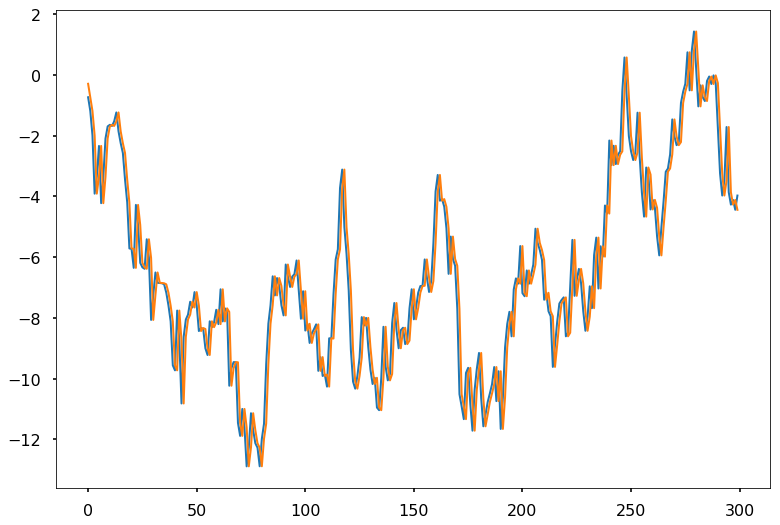

In [9]:
matrix = trajectory_matrix(np.array(df_wn.series1), 700)

X_train, X_test, y_train, y_test = train_test_split(matrix[:,:-1],
                                                    matrix[:,-1:], 
                                                    test_size=300, 
                                                    random_state=42,
                                                    shuffle=False
                                                   )

insight_prediction = X_test[:,-1:]
print('MSE for one series: {}'.format(mean_squared_error(y_test, insight_prediction)))

plt.plot(y_test, linewidth=2)
plt.plot(insight_prediction, linewidth=2)
plt.show()

Наблюдается сдвиг на одну точку. Теперь посмотрим на среднюю ошибку для всех 100 рядов.

In [10]:
mse_list = []
for i in range(1,101):
    matrix = trajectory_matrix(np.array(df_wn['series' + str(i)]), 700)

    X_train, X_test, y_train, y_test = train_test_split(matrix[:,:-1],
                                                        matrix[:,-1:], 
                                                        test_size=300, 
                                                        random_state=42,
                                                        shuffle=False
                                                       )

    insight_prediction = X_test[:,-1:]
    mse_list.append(mean_squared_error(y_test, insight_prediction))


print('Average MSE for 100 series: {}'.format(np.mean(mse_list)))


Average MSE for 100 series: 1.0106999202433393


In [115]:
def lasso_regression(x,y,intercept):
    params={'alpha':np.linspace(0.1,1.0,20)}
    model=sklearn.linear_model.LassoCV(params,verbose=False,n_jobs=-1, cv=5, fit_intercept=intercept).fit(x, y)
    return(model.best_score,model.best_params_)


    

In [155]:
def linear_regression(x,y,intercept):
    model=linear_model.LinearRegression(fit_intercept=intercept)
    scores = cross_val_score(model, x, y, cv=5, scoring='neg_mean_squared_error')
    return(scores.mean())

    

In [158]:
def stats(mse,mse_train_final,case):
    res = {'Mean test MSE': np.mean(mse),
           '+/- test': 2 * np.std(mse) / np.sqrt(1000),
           'Mean train MSE': np.mean(mse_train_final),
           '+/- train': 2 * np.std(mse_train_final) / np.sqrt(1000)}
    df=pd.DataFrame(res)
    df.to_csv(case)
    return(df)
           

Теперь воспользуемся линейной регрессией для предсказания. Перейдем к разностям. Также будем подбирать длину окна на решетке от 10 до 100 с шагом 10 для каждого ряда с помощью кросс-валидации с параметром 5.

То есть:
1) Берем ряд, переходим к разностям
2) Начинаем проход по решетке. Для каждой длины окна строим траекторную матрицу
3) Разделяем на тестовую и тренировочную выборки (300 на тест, 700 на трейн)
4) Теперь на тренировочной выборке начинаем кросс-валидацию и считам среднюю ошибку
5) Выбираем длину окна, для которой ошибка из пункта 4 была минимальной
6) Обучаем модель с выбранной длиной окна теперь уже на всей тренировочной выборке (без кросс-валидации), проверяем на тестовой выборке

Повторяем для всех рядов.

То же самое делаем и для Lasso-регрессии, однако там еще подбираем параметр регуляризации.

Будем проверять для двух случаев: со свободным членом и без него. Результаты сохраняем и позже выведем в таблицу


In [126]:
#Есть свободный член
train=[]
test=[]
ks=[]
for i in range(1,101):
    mse_list_train = []
    for k in np.linspace(10,100,10):
        matrix = trajectory_matrix(np.array(df_wn['series' + str(i)]), int(k)).transpose()
        matrix_diff=np.diff(matrix)
        X_train, X_test, y_train, y_test = train_test_split(matrix_diff[:,:-1],
                                                            matrix_diff[:,-1:], 
                                                            test_size=300, 
                                                            random_state=42,
                                                            shuffle=False
                                                           )
        
        
        mse_list_train.append(-linear_regression(X_train,y_train,True))
    
    ks.append(mse_list_train.index(min(mse_list_train))*10)
    
for i in range(1,101):
    matrix = trajectory_matrix(np.array(df_wn['series' + str(i)]), int(ks[i])).transpose()
    matrix_diff=np.diff(matrix)
    X_train, X_test, y_train, y_test = train_test_split(matrix_diff[:,:-1],
                                                            matrix_diff[:,-1:], 
                                                            test_size=300, 
                                                            random_state=42,
                                                            shuffle=False
                                                           )
    model=linear_model.LinearRegression(fit_intercept=True)
    model.fit(X_train, y_train)
    test.append(mean_squared_error(y_test, model.predict(X_test)))
results_name.append("white_noise_LR_intercept")
stats(test,train,"white_noise_LR_intercept")
results_test_mse.append(np.mean(test))
results_train_mse.append(np.mean(train))
    


In [129]:
#Нет свободного члена
train=[]
test=[]
ks=[]
for i in range(1,101):
    mse_list_train = []
    for k in np.linspace(10,100,10):
        matrix = trajectory_matrix(np.array(df_wn['series' + str(i)]), int(k)).transpose()
        matrix_diff=np.diff(matrix)
        X_train, X_test, y_train, y_test = train_test_split(matrix_diff[:,:-1],
                                                            matrix_diff[:,-1:], 
                                                            test_size=300, 
                                                            random_state=42,
                                                            shuffle=False
                                                           )
        
        
        mse_list_train.append(-linear_regression(X_train,y_train,False))
    
    ks.append(mse_list_train.index(min(mse_list_train))*10)
    
for i in range(1,101):
    matrix = trajectory_matrix(np.array(df_wn['series' + str(i)]), int(ks[i])).transpose()
    matrix_diff=np.diff(matrix)
    X_train, X_test, y_train, y_test = train_test_split(matrix_diff[:,:-1],
                                                            matrix_diff[:,-1:], 
                                                            test_size=300, 
                                                            random_state=42,
                                                            shuffle=False
                                                           )
    model=linear_model.LinearRegression(fit_intercept=False)
    model.fit(X_train, y_train)
    test.append(mean_squared_error(y_test, model.predict(X_test)))
results_name.append("white_noise_LR_no_intercept")
a=stats(test,train,"white_noise_LR_no_intercept")
results_test_mse.append(np.mean(test))
results_train_mse.append(np.mean(train))

    


In [130]:
#Lasso-регрессия со свободным членом

train=[]
test=[]
ks=[]
alphas=[]
alpha=[]
for i in range(1,101):
    mse_list_train = []
    for k in np.linspace(10,100,10):
        matrix = trajectory_matrix(np.array(df_wn['series' + str(i)]), int(k)).transpose()
        matrix_diff=np.diff(matrix)
        X_train, X_test, y_train, y_test = train_test_split(matrix_diff[:,:-1],
                                                            matrix_diff[:,-1:], 
                                                            test_size=300, 
                                                            random_state=42,
                                                            shuffle=False
                                                           )
        
        
        mse_list_train.append(-lasso_regression(X_train,y_train,True)[0])
        alphas.append(lasso_regression(X_train,y_train,True)[1])
    
    ks.append(mse_list_train.index(min(mse_list_train))*10)
    alpha.append(alphas[ks[-1]/10])
    
for i in range(1,101):
    matrix = trajectory_matrix(np.array(df_wn['series' + str(i)]), int(ks[i])).transpose()
    matrix_diff=np.diff(matrix)
    X_train, X_test, y_train, y_test = train_test_split(matrix_diff[:,:-1],
                                                            matrix_diff[:,-1:], 
                                                            test_size=300, 
                                                            random_state=42,
                                                            shuffle=False
                                                           )
    model=linear_model.LassoRegression(fit_intercept=True,alpha=alpha[i])
    model.fit(X_train, y_train)
    test.append(mean_squared_error(y_test, model.predict(X_test)))
results_name.append("white_noise_LassoR_intercept")
a=stats(test,train,"white_noise_LassoR_intercept")
results_test_mse.append(np.mean(test))
results_train_mse.append(np.mean(train))
    


In [131]:
#Lasso-регрессия без свободного члена

train=[]
test=[]
ks=[]
alphas=[]
alpha=[]
for i in range(1,101):
    mse_list_train = []
    for k in np.linspace(10,100,10):
        matrix = trajectory_matrix(np.array(df_wn['series' + str(i)]), int(k)).transpose()
        matrix_diff=np.diff(matrix)
        X_train, X_test, y_train, y_test = train_test_split(matrix_diff[:,:-1],
                                                            matrix_diff[:,-1:], 
                                                            test_size=300, 
                                                            random_state=42,
                                                            shuffle=False
                                                           )
        
        
        mse_list_train.append(-lasso_regression(X_train,y_train,False)[0])
        alphas.append(lasso_regression(X_train,y_train,False)[1])
    
    ks.append(mse_list_train.index(min(mse_list_train))*10)
    alpha.append(alphas[ks[-1]/10])
    
for i in range(1,101):
    matrix = trajectory_matrix(np.array(df_wn['series' + str(i)]), int(ks[i])).transpose()
    matrix_diff=np.diff(matrix)
    X_train, X_test, y_train, y_test = train_test_split(matrix_diff[:,:-1],
                                                            matrix_diff[:,-1:], 
                                                            test_size=300, 
                                                            random_state=42,
                                                            shuffle=False
                                                           )
    model=linear_model.LassoRegression(fit_intercept=False,alpha=alpha[i])
    model.fit(X_train, y_train)
    test.append(mean_squared_error(y_test, model.predict(X_test)))
results_name.append("white_noise_LassoR_no_intercept")
a=stats(test,train,"white_noise_LassoR_no_intercept")
results_test_mse.append(np.mean(test))
results_train_mse.append(np.mean(train))
    


Будем повторять все то же самое для остальных рядов. Для самого сложного из них (последнего) применим дополнительно метод SVM.

## Линейный тренд

MSE for one series: 1.6021239077768602e-28


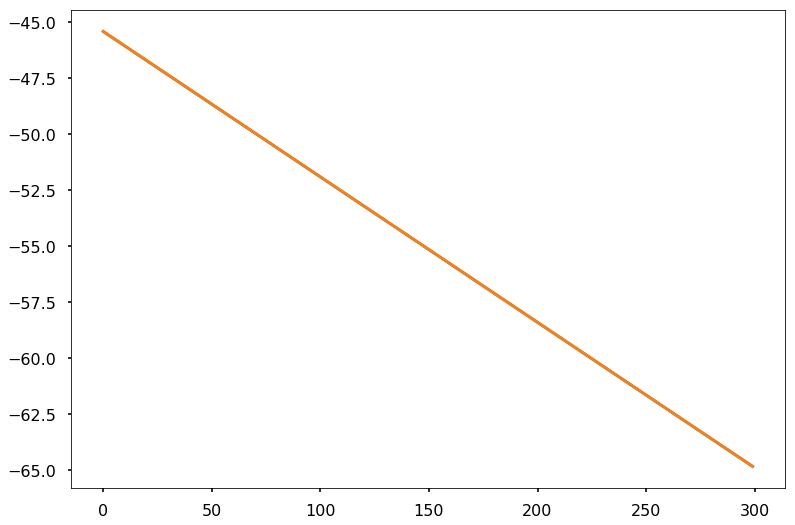

In [132]:
matrix = trajectory_matrix(np.array(df_lt['series1']), 700)

X_train, X_test, y_train, y_test = train_test_split(matrix[:,:-1],
                                                    matrix[:,-1:], 
                                                    test_size=300, 
                                                    random_state=42,
                                                    shuffle=False
                                                   )

insight_prediction = X_test[:,-1:] + (X_test[:,-1:]-X_test[:,-2:-1])
print('MSE for one series: {}'.format(mean_squared_error(y_test, insight_prediction)))

plt.plot(y_test)
plt.plot(insight_prediction)
plt.show()

Будем повторять все то же самое для остальных рядов

In [133]:
mse_list = []
for i in range(1,101):
    matrix = trajectory_matrix(np.array(df_lt['series' + str(i)]), 700)

    X_train, X_test, y_train, y_test = train_test_split(matrix[:,:-1],
                                                        matrix[:,-1:], 
                                                        test_size=300, 
                                                        random_state=42,
                                                        shuffle=False
                                                       )

    insight_prediction = X_test[:,-1:] + (X_test[:,-1:]-X_test[:,-2:-1])
    mse_list.append(mean_squared_error(y_test, insight_prediction))


print('Average MSE for 100 series: {}'.format(np.mean(mse_list)))

Average MSE for 100 series: 1.3836392901568296e-26


In [134]:
#Есть свободный член
train=[]
test=[]
ks=[]
for i in range(1,101):
    mse_list_train = []
    for k in np.linspace(10,100,10):
        matrix = trajectory_matrix(np.array(df_lt['series' + str(i)]), int(k)).transpose()
        matrix_diff=np.diff(matrix)
        X_train, X_test, y_train, y_test = train_test_split(matrix_diff[:,:-1],
                                                            matrix_diff[:,-1:], 
                                                            test_size=300, 
                                                            random_state=42,
                                                            shuffle=False
                                                           )
        
        
        mse_list_train.append(-linear_regression(X_train,y_train,True))
    
    ks.append(mse_list_train.index(min(mse_list_train))*10)
    
for i in range(1,101):
    matrix = trajectory_matrix(np.array(df_lt['series' + str(i)]), int(ks[i])).transpose()
    matrix_diff=np.diff(matrix)
    X_train, X_test, y_train, y_test = train_test_split(matrix_diff[:,:-1],
                                                            matrix_diff[:,-1:], 
                                                            test_size=300, 
                                                            random_state=42,
                                                            shuffle=False
                                                           )
    model=linear_model.LinearRegression(fit_intercept=True)
    model.fit(X_train, y_train)
    test.append(mean_squared_error(y_test, model.predict(X_test)))
results_name.append("linear_trend_LR_intercept")
a=stats(test,train,"linear_trend_LR_intercept")
results_test_mse.append(np.mean(test))
results_train_mse.append(np.mean(train))

In [137]:
#Нет свободного члена
train=[]
test=[]
ks=[]
for i in range(1,101):
    mse_list_train = []
    for k in np.linspace(10,100,10):
        matrix = trajectory_matrix(np.array(df_lt['series' + str(i)]), int(k)).transpose()
        matrix_diff=np.diff(matrix)
        X_train, X_test, y_train, y_test = train_test_split(matrix_diff[:,:-1],
                                                            matrix_diff[:,-1:], 
                                                            test_size=300, 
                                                            random_state=42,
                                                            shuffle=False
                                                           )
        
        
        mse_list_train.append(-linear_regression(X_train,y_train,False))
    
    ks.append(mse_list_train.index(min(mse_list_train))*10)
    
for i in range(1,101):
    matrix = trajectory_matrix(np.array(df_lt['series' + str(i)]), int(ks[i])).transpose()
    matrix_diff=np.diff(matrix)
    X_train, X_test, y_train, y_test = train_test_split(matrix_diff[:,:-1],
                                                            matrix_diff[:,-1:], 
                                                            test_size=300, 
                                                            random_state=42,
                                                            shuffle=False
                                                           )
    model=linear_model.LinearRegression(fit_intercept=False)
    model.fit(X_train, y_train)
    test.append(mean_squared_error(y_test, model.predict(X_test)))
results_name.append("linear_trend_LR_no_intercept")
results_test_mse.append(np.mean(test))
a=stats(test,train,"linear_trend_LR_no_intercept")
results_train_mse.append(np.mean(train))

    


In [138]:
#Lasso-регрессия со свободным членом

train=[]
test=[]
ks=[]
alphas=[]
alpha=[]
for i in range(1,101):
    mse_list_train = []
    for k in np.linspace(10,100,10):
        matrix = trajectory_matrix(np.array(df_lt['series' + str(i)]), int(k)).transpose()
        matrix_diff=np.diff(matrix)
        X_train, X_test, y_train, y_test = train_test_split(matrix_diff[:,:-1],
                                                            matrix_diff[:,-1:], 
                                                            test_size=300, 
                                                            random_state=42,
                                                            shuffle=False
                                                           )
        
        
        mse_list_train.append(-lasso_regression(X_train,y_train,True)[0])
        alphas.append(lasso_regression(X_train,y_train,True)[1])
    
    ks.append(mse_list_train.index(min(mse_list_train))*10)
    alpha.append(alphas[ks[-1]/10])
    
for i in range(1,101):
    matrix = trajectory_matrix(np.array(df_lt['series' + str(i)]), int(ks[i])).transpose()
    matrix_diff=np.diff(matrix)
    X_train, X_test, y_train, y_test = train_test_split(matrix_diff[:,:-1],
                                                            matrix_diff[:,-1:], 
                                                            test_size=300, 
                                                            random_state=42,
                                                            shuffle=False
                                                           )
    model=linear_model.LassoRegression(fit_intercept=True,alpha=alpha[i])
    model.fit(X_train, y_train)
    test.append(mean_squared_error(y_test, model.predict(X_test)))
results_name.append("linear_trend_LassoR_intercept")
a=stats(test,train,"linear_trend_LassoR_intercept")
results_test_mse.append(np.mean(test))
results_train_mse.append(np.mean(train))
    


In [139]:
#Lasso-регрессия без свободного члена

train=[]
test=[]
ks=[]
alphas=[]
alpha=[]
for i in range(1,101):
    mse_list_train = []
    for k in np.linspace(10,100,10):
        matrix = trajectory_matrix(np.array(df_lt['series' + str(i)]), int(k)).transpose()
        matrix_diff=np.diff(matrix)
        X_train, X_test, y_train, y_test = train_test_split(matrix_diff[:,:-1],
                                                            matrix_diff[:,-1:], 
                                                            test_size=300, 
                                                            random_state=42,
                                                            shuffle=False
                                                           )
        
        
        mse_list_train.append(-lasso_regression(X_train,y_train,False)[0])
        alphas.append(lasso_regression(X_train,y_train,False)[1])
    
    ks.append(mse_list_train.index(min(mse_list_train))*10)
    alpha.append(alphas[ks[-1]/10])
    
for i in range(1,101):
    matrix = trajectory_matrix(np.array(df_lt['series' + str(i)]), int(ks[i])).transpose()
    matrix_diff=np.diff(matrix)
    X_train, X_test, y_train, y_test = train_test_split(matrix_diff[:,:-1],
                                                            matrix_diff[:,-1:], 
                                                            test_size=300, 
                                                            random_state=42,
                                                            shuffle=False
                                                           )
    model=linear_model.LassoRegression(fit_intercept=False,alpha=alpha[i])
    model.fit(X_train, y_train)
    test.append(mean_squared_error(y_test, model.predict(X_test)))
results_name.append("linear_trend_LassoR_no_intercept")
a=stats(test,train,"linear_trend_LassoR_no_intercept")
results_test_mse.append(np.mean(test))
results_train_mse.append(np.mean(train))
    


## Линейный тренд с броуновским движением

MSE for one series: 0.842329301228


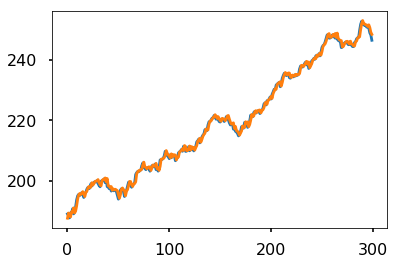

In [31]:
matrix = trajectory_matrix(np.array(df_lt_wn['series1']), 700)

X_train, X_test, y_train, y_test = train_test_split(matrix[:,:-1],
                                                    matrix[:,-1:], 
                                                    test_size=300, 
                                                    random_state=42,
                                                    shuffle=False
                                                   )

insight_prediction = X_test[:,-1:] + np.mean(np.diff(X_test), axis=1).reshape(-1,1)
print('MSE for one series: {}'.format(mean_squared_error(y_test, insight_prediction)))

plt.plot(y_test)
plt.plot(insight_prediction)
plt.show()

In [140]:
mse_list = []
for i in range(1,101):
    matrix = trajectory_matrix(np.array(df_lt_wn['series' + str(i)]), 700)

    X_train, X_test, y_train, y_test = train_test_split(matrix[:,:-1],
                                                        matrix[:,-1:], 
                                                        test_size=300, 
                                                        random_state=42,
                                                        shuffle=False
                                                       )

    insight_prediction = X_test[:,-1:] + np.mean(np.diff(X_test),axis=1).reshape(-1,1)
    mse_list.append(mean_squared_error(y_test, insight_prediction))


print('Average MSE for 100 series: {}'.format(np.mean(mse_list)))


Average MSE for 100 series: 1.013484896717328


In [141]:
#Есть свободный член
train=[]
test=[]
ks=[]
for i in range(1,101):
    mse_list_train = []
    for k in np.linspace(10,100,10):
        matrix = trajectory_matrix(np.array(df_lt_wn['series' + str(i)]), int(k)).transpose()
        matrix_diff=np.diff(matrix)
        X_train, X_test, y_train, y_test = train_test_split(matrix_diff[:,:-1],
                                                            matrix_diff[:,-1:], 
                                                            test_size=300, 
                                                            random_state=42,
                                                            shuffle=False
                                                           )
        
        
        mse_list_train.append(-linear_regression(X_train,y_train,True))
    
    ks.append(mse_list_train.index(min(mse_list_train))*10)
    
for i in range(1,101):
    matrix = trajectory_matrix(np.array(df_lt_wn['series' + str(i)]), int(ks[i])).transpose()
    matrix_diff=np.diff(matrix)
    X_train, X_test, y_train, y_test = train_test_split(matrix_diff[:,:-1],
                                                            matrix_diff[:,-1:], 
                                                            test_size=300, 
                                                            random_state=42,
                                                            shuffle=False
                                                           )
    model=linear_model.LinearRegression(fit_intercept=True)
    model.fit(X_train, y_train)
    test.append(mean_squared_error(y_test, model.predict(X_test)))
results_name.append("linear_trend_wn_LR_intercept")
a=stats(test,train,"linear_trend_wn_LR_intercept")
results_test_mse.append(np.mean(test))
results_train_mse.append(np.mean(train))

In [144]:
#Нет свободного члена
train=[]
test=[]
ks=[]
for i in range(1,101):
    mse_list_train = []
    for k in np.linspace(10,100,10):
        matrix = trajectory_matrix(np.array(df_lt_wn['series' + str(i)]), int(k)).transpose()
        matrix_diff=np.diff(matrix)
        X_train, X_test, y_train, y_test = train_test_split(matrix_diff[:,:-1],
                                                            matrix_diff[:,-1:], 
                                                            test_size=300, 
                                                            random_state=42,
                                                            shuffle=False
                                                           )
        
        
        mse_list_train.append(-linear_regression(X_train,y_train,False))
    
    ks.append(mse_list_train.index(min(mse_list_train))*10)
    
for i in range(1,101):
    matrix = trajectory_matrix(np.array(df_lt_wn['series' + str(i)]), int(ks[i])).transpose()
    matrix_diff=np.diff(matrix)
    X_train, X_test, y_train, y_test = train_test_split(matrix_diff[:,:-1],
                                                            matrix_diff[:,-1:], 
                                                            test_size=300, 
                                                            random_state=42,
                                                            shuffle=False
                                                           )
    model=linear_model.LinearRegression(fit_intercept=False)
    model.fit(X_train, y_train)
    test.append(mean_squared_error(y_test, model.predict(X_test)))
results_name.append("linear_trend_wn_LR_no_intercept")
a=stats(test,train,"linear_trend_wn_LR_no_intercept")
results_test_mse.append(np.mean(test))
results_train_mse.append(np.mean(train))

    


In [145]:
#Lasso-регрессия со свободным членом

train=[]
test=[]
ks=[]
alphas=[]
alpha=[]
for i in range(1,101):
    mse_list_train = []
    for k in np.linspace(10,100,10):
        matrix = trajectory_matrix(np.array(df_lt_wn['series' + str(i)]), int(k)).transpose()
        matrix_diff=np.diff(matrix)
        X_train, X_test, y_train, y_test = train_test_split(matrix_diff[:,:-1],
                                                            matrix_diff[:,-1:], 
                                                            test_size=300, 
                                                            random_state=42,
                                                            shuffle=False
                                                           )
        
        
        mse_list_train.append(-lasso_regression(X_train,y_train,True)[0])
        alphas.append(lasso_regression(X_train,y_train,True)[1])
    
    ks.append(mse_list_train.index(min(mse_list_train))*10)
    alpha.append(alphas[ks[-1]/10])
    
for i in range(1,101):
    matrix = trajectory_matrix(np.array(df_lt_wn['series' + str(i)]), int(ks[i])).transpose()
    matrix_diff=np.diff(matrix)
    X_train, X_test, y_train, y_test = train_test_split(matrix_diff[:,:-1],
                                                            matrix_diff[:,-1:], 
                                                            test_size=300, 
                                                            random_state=42,
                                                            shuffle=False
                                                           )
    model=linear_model.LassoRegression(fit_intercept=True,alpha=alpha[i])
    model.fit(X_train, y_train)
    test.append(mean_squared_error(y_test, model.predict(X_test)))
results_name.append("linear_trend_LassoR_intercept")
a=stats(test,train,"linear_trend_LassoR_intercept")
results_test_mse.append(np.mean(test))
results_train_mse.append(np.mean(train))
    


In [146]:
#Lasso-регрессия без свободного члена

train=[]
test=[]
ks=[]
alphas=[]
alpha=[]
for i in range(1,101):
    mse_list_train = []
    for k in np.linspace(10,100,10):
        matrix = trajectory_matrix(np.array(df_lt_wn['series' + str(i)]), int(k)).transpose()
        matrix_diff=np.diff(matrix)
        X_train, X_test, y_train, y_test = train_test_split(matrix_diff[:,:-1],
                                                            matrix_diff[:,-1:], 
                                                            test_size=300, 
                                                            random_state=42,
                                                            shuffle=False
                                                           )
        
        
        mse_list_train.append(-lasso_regression(X_train,y_train,False)[0])
        alphas.append(lasso_regression(X_train,y_train,False)[1])
    
    ks.append(mse_list_train.index(min(mse_list_train))*10)
    alpha.append(alphas[ks[-1]/10])
    
for i in range(1,101):
    matrix = trajectory_matrix(np.array(df_lt_wn['series' + str(i)]), int(ks[i])).transpose()
    matrix_diff=np.diff(matrix)
    X_train, X_test, y_train, y_test = train_test_split(matrix_diff[:,:-1],
                                                            matrix_diff[:,-1:], 
                                                            test_size=300, 
                                                            random_state=42,
                                                            shuffle=False
                                                           )
    model=linear_model.LassoRegression(fit_intercept=False,alpha=alpha[i])
    model.fit(X_train, y_train)
    test.append(mean_squared_error(y_test, model.predict(X_test)))
results_name.append("linear_trend_wn_LassoR_no_intercept")
a=stats(test,train,"linear_trend_wn_LassoR_no_intercept")
results_test_mse.append(np.mean(test))
results_train_mse.append(np.mean(train))
    


## Линейный тренд с изломами и броуновским движением

Необходимо подобрать параметр $k$, который отвечает за число точек, по которым мы считаем среднее приращение. Будем перебирать по решетке.

Будем подбирать и предсказывать сначала для одного ряда.

In [26]:
%%time
k_list = [i for i in range(10,40)]
k_final_list=[]
for i in range(1,101):
    mse_list = []
    for k in k_list:
        
        matrix = trajectory_matrix(np.array(df_lt_d_wn['series' + str(i)]), 700)

        X_train, X_test, y_train, y_test = train_test_split(matrix[:,:-1],
                                                                matrix[:,-1:], 
                                                                test_size=300, 
                                                                random_state=42,
                                                                shuffle=False
                                                               )

        insight_prediction = X_train[:,-1:] + np.mean(np.diff(X_train)[:,-k:],axis=1).reshape(-1,1)
        mse_list.append(mean_squared_error(y_train, insight_prediction))
    k_final_list.append(k_list[mse_list.index(np.min(mse_list))])      
print(k_final_list)
#print('Optimal k is {}'.format([k_list[counter] for counter, i in enumerate(mse_list_avg) if i == min(mse_list_avg)][0]))
#plt.plot(k_list, mse_list_avg)
#plt.show()

[17, 30, 33, 16, 26, 18, 24, 32, 38, 11, 34, 39, 11, 39, 20, 26, 25, 38, 32, 16, 22, 32, 21, 23, 39, 39, 33, 27, 35, 33, 18, 17, 28, 36, 24, 17, 19, 34, 38, 23, 39, 35, 29, 39, 22, 37, 39, 39, 18, 24, 39, 11, 23, 39, 24, 27, 38, 35, 14, 37, 35, 30, 38, 39, 32, 32, 38, 32, 39, 12, 29, 22, 31, 17, 21, 16, 32, 16, 37, 20, 17, 39, 36, 22, 38, 23, 26, 38, 39, 20, 22, 19, 34, 25, 38, 39, 24, 13, 18, 39]
Wall time: 5min 22s


MSE for one series: 1.05764146655


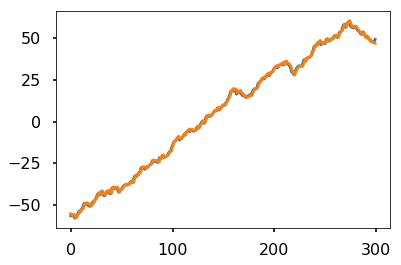

In [24]:
matrix = trajectory_matrix(np.array(df_lt_d_wn['series1']), 700)
k = k_final_list[0]

X_train, X_test, y_train, y_test = train_test_split(matrix[:,:-1],
                                                    matrix[:,-1:], 
                                                    test_size=300, 
                                                   random_state=42,
                                                    shuffle=False
                                                   )

insight_prediction = X_test[:,-1:] + np.mean(np.diff(X_test)[:,-k:],axis=1).reshape(-1,1)
print('MSE for one series: {}'.format(mean_squared_error(y_test, insight_prediction)))

plt.plot(y_test)
plt.plot(insight_prediction)
plt.show()

Average MSE for 100 series: 1.07740195152


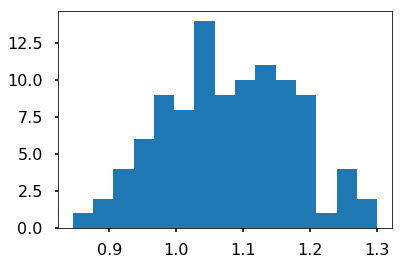

In [25]:
mse_list = []

for i in range(1,101):
    matrix = trajectory_matrix(np.array(df_lt_d_wn['series' + str(i)]), 700)

    X_train, X_test, y_train, y_test = train_test_split(matrix[:,:-1],
                                                        matrix[:,-1:], 
                                                        test_size=300, 
                                                        random_state=42,
                                                        shuffle=False
                                                       )

    insight_prediction = X_test[:,-1:] + np.mean(np.diff(X_test)[:,-k_final_list[i-1]:],axis=1).reshape(-1,1)
    mse_list.append(mean_squared_error(y_test, insight_prediction))


print('Average MSE for 100 series: {}'.format(np.mean(mse_list)))
plt.hist(mse_list, bins=15)
plt.show()

In [147]:
#Есть свободный член
train=[]
test=[]
ks=[]
for i in range(1,101):
    mse_list_train = []
    for k in np.linspace(10,100,10):
        matrix = trajectory_matrix(np.array(df_lt_d_wn['series' + str(i)]), int(k)).transpose()
        matrix_diff=np.diff(matrix)
        X_train, X_test, y_train, y_test = train_test_split(matrix_diff[:,:-1],
                                                            matrix_diff[:,-1:], 
                                                            test_size=300, 
                                                            random_state=42,
                                                            shuffle=False
                                                           )
        
        
        mse_list_train.append(-linear_regression(X_train,y_train,True))
    
    ks.append(mse_list_train.index(min(mse_list_train))*10)
    
for i in range(1,101):
    matrix = trajectory_matrix(np.array(df_lt_d_wn['series' + str(i)]), int(ks[i])).transpose()
    matrix_diff=np.diff(matrix)
    X_train, X_test, y_train, y_test = train_test_split(matrix_diff[:,:-1],
                                                            matrix_diff[:,-1:], 
                                                            test_size=300, 
                                                            random_state=42,
                                                            shuffle=False
                                                           )
    model=linear_model.LinearRegression(fit_intercept=True)
    model.fit(X_train, y_train)
    test.append(mean_squared_error(y_test, model.predict(X_test)))
results_name.append("linear_trend_d_wn_LR_intercept")
a=stats(test,train,"linear_trend_d_wn_LR_intercept")
results_test_mse.append(np.mean(test))
results_train_mse.append(np.mean(train))

In [148]:
#Нет свободного члена
train=[]
test=[]
ks=[]
for i in range(1,101):
    mse_list_train = []
    for k in np.linspace(10,100,10):
        matrix = trajectory_matrix(np.array(df_lt_d_wn['series' + str(i)]), int(k)).transpose()
        matrix_diff=np.diff(matrix)
        X_train, X_test, y_train, y_test = train_test_split(matrix_diff[:,:-1],
                                                            matrix_diff[:,-1:], 
                                                            test_size=300, 
                                                            random_state=42,
                                                            shuffle=False
                                                           )
        
        
        mse_list_train.append(-linear_regression(X_train,y_train,False))
    
    ks.append(mse_list_train.index(min(mse_list_train))*10)
    
for i in range(1,101):
    matrix = trajectory_matrix(np.array(df_lt_d_wn['series' + str(i)]), int(ks[i])).transpose()
    matrix_diff=np.diff(matrix)
    X_train, X_test, y_train, y_test = train_test_split(matrix_diff[:,:-1],
                                                            matrix_diff[:,-1:], 
                                                            test_size=300, 
                                                            random_state=42,
                                                            shuffle=False
                                                           )
    model=linear_model.LinearRegression(fit_intercept=False)
    model.fit(X_train, y_train)
    test.append(mean_squared_error(y_test, model.predict(X_test)))
results_name.append("linear_trend_d_wn_LR_no_intercept")
a=stats(test,train,"linear_trend_d_wn_LR_no_intercept")
results_test_mse.append(np.mean(test))
results_train_mse.append(np.mean(train))

    


In [149]:
#Lasso-регрессия без свободного члена

train=[]
test=[]
ks=[]
alphas=[]
alpha=[]
for i in range(1,101):
    mse_list_train = []
    for k in np.linspace(10,100,10):
        matrix = trajectory_matrix(np.array(df_lt_d_wn['series' + str(i)]), int(k)).transpose()
        matrix_diff=np.diff(matrix)
        X_train, X_test, y_train, y_test = train_test_split(matrix_diff[:,:-1],
                                                            matrix_diff[:,-1:], 
                                                            test_size=300, 
                                                            random_state=42,
                                                            shuffle=False
                                                           )
        
        
        mse_list_train.append(-lasso_regression(X_train,y_train,False)[0])
        alphas.append(lasso_regression(X_train,y_train,False)[1])
    
    ks.append(mse_list_train.index(min(mse_list_train))*10)
    alpha.append(alphas[ks[-1]/10])
    
for i in range(1,101):
    matrix = trajectory_matrix(np.array(df_lt_d_wn['series' + str(i)]), int(ks[i])).transpose()
    matrix_diff=np.diff(matrix)
    X_train, X_test, y_train, y_test = train_test_split(matrix_diff[:,:-1],
                                                            matrix_diff[:,-1:], 
                                                            test_size=300, 
                                                            random_state=42,
                                                            shuffle=False
                                                           )
    model=linear_model.LassoRegression(fit_intercept=False,alpha=alpha[i])
    model.fit(X_train, y_train)
    test.append(mean_squared_error(y_test, model.predict(X_test)))
results_name.append("linear_trend_d_wn_LassoR_no_intercept")
a=stats(test,train,"linear_trend_d_wn_LassoR_no_intercept")
results_test_mse.append(np.mean(test))
results_train_mse.append(np.mean(train))
    


In [150]:
#Lasso-регрессия со свободным членом

train=[]
test=[]
ks=[]
alphas=[]
alpha=[]
for i in range(1,101):
    mse_list_train = []
    for k in np.linspace(10,100,10):
        matrix = trajectory_matrix(np.array(df_lt_d_wn['series' + str(i)]), int(k)).transpose()
        matrix_diff=np.diff(matrix)
        X_train, X_test, y_train, y_test = train_test_split(matrix_diff[:,:-1],
                                                            matrix_diff[:,-1:], 
                                                            test_size=300, 
                                                            random_state=42,
                                                            shuffle=False
                                                           )
        
        
        mse_list_train.append(-lasso_regression(X_train,y_train,True)[0])
        alphas.append(lasso_regression(X_train,y_train,True)[1])
    
    ks.append(mse_list_train.index(min(mse_list_train))*10)
    alpha.append(alphas[ks[-1]/10])
    
for i in range(1,101):
    matrix = trajectory_matrix(np.array(df_lt_d_wn['series' + str(i)]), int(ks[i])).transpose()
    matrix_diff=np.diff(matrix)
    X_train, X_test, y_train, y_test = train_test_split(matrix_diff[:,:-1],
                                                            matrix_diff[:,-1:], 
                                                            test_size=300, 
                                                            random_state=42,
                                                            shuffle=False
                                                           )
    model=linear_model.LassoRegression(fit_intercept=True,alpha=alpha[i])
    model.fit(X_train, y_train)
    test.append(mean_squared_error(y_test, model.predict(X_test)))
results_name.append("linear_trend_d_wn_LassoR_intercept")
a=stats(test,train,"linear_trend_d_wn_LassoR_intercept")
results_test_mse.append(np.mean(test))
results_train_mse.append(np.mean(train))
    


In [154]:
def my_svm(x,y):
    model=svm.SVR()
    params={ 'C': [0.01, 0.025, 0.05, 0.075, 0.1]}
    grid_search = GridSearchCV(model, params, n_jobs=-1, verbose=2, cv=5)
    grid_search.fit(x,y)
    return(mean_squared_error(y, grid_search.predict(x)),grid_search.best_params_)
    

## Применение SVM

Напомним, что гиперпараметрами для метода SVM являются ядро, степень ядра, если оно полиномиальное, а также параметр регуляризации. Остановимся на том, что наиболее подходящим будем считать линейное ядро. 
Будем также подбирать и длину окна. Все вычисления будем производить на разностях.

In [34]:
from sklearn import svm

In [49]:
train=[]
test=[]
ks=[]
cs=[]
c=[]
for i in range(1,101):
    mse_list_train = []
    for k in np.linspace(10,100,10):
        matrix = trajectory_matrix(np.array(df_lt_d_wn['series' + str(i)]), int(k)).transpose()
        matrix_diff=np.diff(matrix)
        X_train, X_test, y_train, y_test = train_test_split(matrix_diff[:,:-1],
                                                            matrix_diff[:,-1:], 
                                                            test_size=300, 
                                                            random_state=42,
                                                            shuffle=False
                                                           )
        
        
        mse_list_train.append(my_svm(X_train,y_train)[0])
        cs.append(my_svm(X_train,y_train)[1])
    
    ks.append(mse_list_train.index(min(mse_list_train))*10)
    c.append(cs[ks[-1]/10])
    
for i in range(1,101):
    matrix = trajectory_matrix(np.array(df_lt_d_wn['series' + str(i)]), int(ks[i])).transpose()
    matrix_diff=np.diff(matrix)
    X_train, X_test, y_train, y_test = train_test_split(matrix_diff[:,:-1],
                                                            matrix_diff[:,-1:], 
                                                            test_size=300, 
                                                            random_state=42,
                                                            shuffle=False
                                                           )
    model=svm.SVR(C=c[i])
    model.fit(X_train, y_train)
    test.append(mean_squared_error(y_test, model.predict(X_test)))
results_name.append("svm")
a=stats(test,train,"svm")
results_test_mse.append(np.mean(test))
results_train_mse.append(np.mean(train))

# Результаты

Попутно мы вычисляли доверительные интервалы для каждой из ошибок. Покажем теперь все результаты в таблицах.

Для белого шума

In [163]:
df_wn=pd.read_csv("White_noise.txt",sep='\t')

In [164]:
df_wn

,+/- test,+/- train,mse test,mse train,Method,Unnamed: 5
0,0.019120,0.010592,1.022579,0.977930,LR no intercept,NaN
1,0.019030,0.010473,1.024650,0.976520,LR intercept,NaN
2,0.018251,0.010337,1.013206,0.981953,LASSO without intercept,NaN
3,0.018946,0.010463,1.020624,0.983879,LASSO with intercept,NaN


Для линейного тренда

In [165]:
df_lt=pd.read_csv("linear_trend.txt",sep='\t')

In [166]:
df_lt

,+/- test,+/- train,mse_test,mse_train,Method,Unnamed: 5
0,1.672553e-28,3.386371e-29,7.479611e-28,1.328080e-28,LR no intercept,NaN
1,1.340491e-28,2.959547e-29,5.989137e-28,1.132848e-28,LR intercept,NaN
2,1.586992e-08,1.586992e-08,6.045742e-08,6.045741e-08,LASSO without intercept,NaN
3,4.813443e-09,4.813442e-09,6.609869e-09,6.609869e-09,LASSO with intercept,NaN


Для линейного тренда с шумом

In [167]:
df_lt_wn=pd.read_csv("trend_noise.txt", sep='\t')

In [168]:
df_lt_wn

,+/- test,+/- train,mse test,mse train,Method
0,0.018331,0.012469,1.063277,1.017572,LR no intercept
1,0.018172,0.010699,1.019974,0.991274,LR intercept
2,0.018323,0.012242,1.047671,0.989930,LASSO without intercept
3,0.018573,0.012755,1.062350,1.015637,LASSO with intercept


И наконец для самого сложного случая - линейного тренда с изломами и шумом

In [169]:
df_final=pd.read_csv("final.txt",sep='\t')

In [170]:
df_final

,+/- test,+/- train,mse test,mse train,Method
0,0.020429,0.011836,1.088201,1.035141,LR no intercept
1,0.039511,0.012553,1.144932,1.027051,LR intercept
2,0.020374,0.012886,1.087146,1.017831,LASSO without intercept
3,0.020250,0.011610,1.088134,1.046301,LASSO with intercept
4,0.039125,0.012616,1.149421,1.025700,SVM
